In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
tf.config.set_visible_devices([], 'GPU')

In [2]:
data=yf.download('0700.hk')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2022-03-31,382.399994,382.399994,372.600006,374.200012,374.200012,14589554,370.133336,375.683334,48.946234,-38.297850,-55.893518,-14.799988,76.200012,375.079281,388.712342,-13.633061,9.799988,-0.625479,-8.055103,378.799988
2022-04-01,367.000000,378.799988,362.200012,378.799988,378.799988,14496674,372.266668,376.666667,52.010099,-28.323747,-47.148318,12.799988,11.799988,375.651697,387.978094,-12.326396,16.599976,6.851465,-4.618128,390.000000
2022-04-04,388.799988,391.000000,383.799988,390.000000,390.000000,15665556,377.866669,376.666667,58.999512,-3.472224,-25.855522,33.600006,0.000000,377.859129,388.127864,-10.268736,12.200012,23.466838,3.532026,381.000000
2022-04-06,383.000000,385.000000,380.000000,381.000000,381.000000,17127923,380.300003,376.666667,51.911489,-34.722237,-42.965786,14.600006,0.000000,378.342340,387.599874,-9.257535,10.000000,5.346744,-3.086421,374.399994
2022-04-07,375.600006,383.600006,373.799988,374.399994,374.399994,15874056,379.833333,376.833333,47.073127,-57.638935,-41.500015,-2.800018,2.000000,377.735825,386.622106,-8.886281,9.800018,-6.702583,-7.801568,369.600006


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [6]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3843, 1, 19) (3843, 1) (428, 1, 19) (428, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_51075/2420511516.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [7]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [8]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300


2022-04-10 14:29:22.005474: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


692/692 [==============================] - 6s 5ms/step - loss: 11272.4082 - val_loss: 910.2711
Epoch 2/300
692/692 [==============================] - 1s 2ms/step - loss: 294.4899 - val_loss: 197.6473
Epoch 3/300
692/692 [==============================] - 2s 3ms/step - loss: 119.7965 - val_loss: 108.7986
Epoch 4/300
692/692 [==============================] - 3s 5ms/step - loss: 81.6542 - val_loss: 79.1930
Epoch 5/300
692/692 [==============================] - 3s 4ms/step - loss: 65.0258 - val_loss: 66.7752
Epoch 6/300
692/692 [==============================] - 2s 3ms/step - loss: 55.8306 - val_loss: 64.6877
Epoch 7/300
692/692 [==============================] - 3s 5ms/step - loss: 50.2719 - val_loss: 62.4348
Epoch 8/300
692/692 [==============================] - 3s 5ms/step - loss: 46.9368 - val_loss: 58.3230
Epoch 9/300
692/692 [==============================] - 2s 4ms/step - loss: 44.9163 - val_loss: 55.7544
Epoch 10/300
692/692 [==============================] - 4s 5ms/step - loss: 4

Epoch 80/300
692/692 [==============================] - 1s 1ms/step - loss: 31.7064 - val_loss: 41.5337
Epoch 81/300
692/692 [==============================] - 1s 1ms/step - loss: 31.3188 - val_loss: 41.8269
Epoch 82/300
692/692 [==============================] - 1s 1ms/step - loss: 31.4196 - val_loss: 41.6886
Epoch 83/300
692/692 [==============================] - 1s 1ms/step - loss: 31.1660 - val_loss: 42.1721
Epoch 84/300
692/692 [==============================] - 1s 1ms/step - loss: 30.9770 - val_loss: 42.1354
Epoch 85/300
692/692 [==============================] - 1s 1ms/step - loss: 30.8245 - val_loss: 42.1428
Epoch 86/300
692/692 [==============================] - 1s 1ms/step - loss: 30.6384 - val_loss: 42.0553
Epoch 87/300
692/692 [==============================] - 1s 1ms/step - loss: 30.5148 - val_loss: 41.9544
Epoch 88/300
692/692 [==============================] - 1s 1ms/step - loss: 30.3420 - val_loss: 41.7406
Epoch 89/300
692/692 [==============================] - 1s 1ms/s

692/692 [==============================] - 1s 1ms/step - loss: 23.3402 - val_loss: 79.3269
Epoch 159/300
692/692 [==============================] - 1s 1ms/step - loss: 23.4219 - val_loss: 74.1423
Epoch 160/300
692/692 [==============================] - 1s 1ms/step - loss: 23.0233 - val_loss: 82.6236
Epoch 161/300
692/692 [==============================] - 1s 1ms/step - loss: 22.9256 - val_loss: 79.5173
Epoch 162/300
692/692 [==============================] - 1s 1ms/step - loss: 22.8759 - val_loss: 76.7982
Epoch 163/300
692/692 [==============================] - 1s 1ms/step - loss: 22.5937 - val_loss: 82.1694
Epoch 164/300
692/692 [==============================] - 1s 1ms/step - loss: 22.5996 - val_loss: 72.0234
Epoch 165/300
692/692 [==============================] - 1s 1ms/step - loss: 22.4034 - val_loss: 88.9279
Epoch 166/300
692/692 [==============================] - 1s 1ms/step - loss: 22.2801 - val_loss: 77.8283
Epoch 167/300
692/692 [==============================] - 1s 1ms/step 

692/692 [==============================] - 1s 1ms/step - loss: 17.9086 - val_loss: 82.4488
Epoch 237/300
692/692 [==============================] - 1s 1ms/step - loss: 17.7867 - val_loss: 77.3571
Epoch 238/300
692/692 [==============================] - 1s 1ms/step - loss: 16.9216 - val_loss: 80.4878
Epoch 239/300
692/692 [==============================] - 1s 1ms/step - loss: 16.8088 - val_loss: 91.3548
Epoch 240/300
692/692 [==============================] - 1s 1ms/step - loss: 17.4614 - val_loss: 79.1772
Epoch 241/300
692/692 [==============================] - 1s 1ms/step - loss: 16.8643 - val_loss: 79.0843
Epoch 242/300
692/692 [==============================] - 1s 1ms/step - loss: 16.5389 - val_loss: 79.4074
Epoch 243/300
692/692 [==============================] - 1s 1ms/step - loss: 16.7856 - val_loss: 78.3871
Epoch 244/300
692/692 [==============================] - 1s 1ms/step - loss: 16.7273 - val_loss: 87.8340
Epoch 245/300
692/692 [==============================] - 1s 1ms/step 

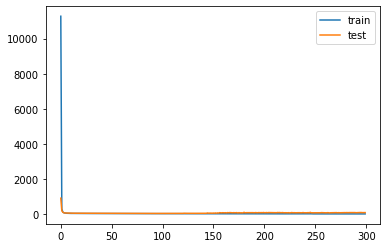

In [9]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

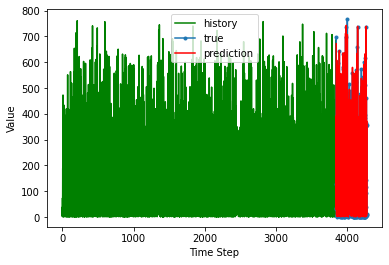

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

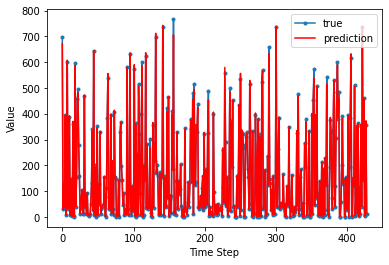

In [11]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [12]:
r2_score(y_test,y_pred)

0.9983790982245901

In [13]:
mean_absolute_percentage_error(y_test,y_pred)

0.07976167587683196

In [14]:
mean_squared_error(y_test,y_pred,squared=False)

7.34834081193803

In [15]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_51075/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


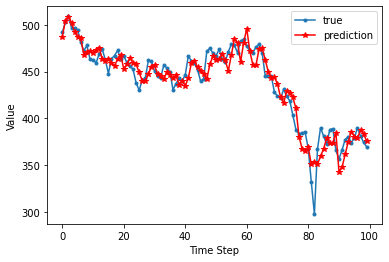

In [16]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [17]:
r2_score(y_val,y_val_pred)

0.9059296803126777

In [18]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.024138255770434727

In [19]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

13.014993691501273